# Directory Setup & Imports

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/SNIPS-dataset")

Mounted at /content/drive


In [2]:
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Making use of GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preprocessing Steps

### Create vocabulary of words & slots from Training Data

In [3]:
vocab = {"<PAD>": 0, "BOS": 1, "EOS": 2, "<unk>": 3}
vocab_size = 4

slots = {"<PAD>": 0, "BOS": 1, "EOS": 2, "<unk>": 3}
slots_size = 4

## Helper functions
# Adding BOS and EOS markers to sentences (input and output)
def addMarkers(lines):
    new_lines = []
    for line in lines:
        new_lines.append("BOS " + line + " EOS")
    return new_lines

# Preparing vocabulary from input sentences
def prepVocab(lines):
    for line in lines:
        for word in line.split():
            if word not in vocab:
                global vocab_size
                vocab[word] = vocab_size
                vocab_size += 1

# Preparing slots/output classes from output sentences
def prepSlots(lines):
    for line in lines:
        for word in line.split():
            if word not in slots:
                global slots_size
                slots[word] = slots_size
                slots_size += 1

# Converting input sentences to indices
def indexFromSentence(lines):
    indices = []
    for line in lines:
        word_indices = []
        for word in line.split():
            #word to idx
            try:
                word_indices.append(vocab[word])
            #If word not exist in vocab - add unknown
            except KeyError as e:
                word_indices.append(vocab["<unk>"])
        indices.append(word_indices)
    return indices

# Converting output sentences to indices
def indexFromSlots(lines):
    indices = []
    for line in lines:
        word_indices = []
        for word in line.split():
            #word to idx
            try:
                word_indices.append(slots[word])
            #If word not exist in slots - add unknown
            except KeyError as e:
                word_indices.append(slots["<unk>"])
        indices.append(word_indices)
    return indices

# Load the training dataset - Using a dataset in the form of a dataframe with indices for sentences (input) and slots (output)
def loadTrainData(seq_in_path, seq_out_path):
    with open(seq_in_path, "r") as file:
        input_sent = file.readlines()
    input_sent = addMarkers(input_sent)
    prepVocab(input_sent)

    with open(seq_out_path, "r") as file:
        output_slots = file.readlines()
    output_slots = addMarkers(output_slots)
    prepSlots(output_slots)

    in_indices = indexFromSentence(input_sent)
    out_indices = indexFromSlots(output_slots)

    df = pd.DataFrame({"sentence": in_indices, "slots": out_indices})
    return df

In [4]:
train_df = loadTrainData("train/seq.in", "train/seq.out")

In [5]:
train_df.tail()

,sentence,slots
13079,"[1, 19, 47, 5, 426, 11417, 110, 24, 215, 59, 1...","[1, 4, 4, 4, 4, 54, 4, 4, 38, 4, 26, 2]"
13080,"[1, 32, 1902, 977, 11418, 2]","[1, 4, 11, 12, 12, 2]"
13081,"[1, 71, 15, 22, 210, 281, 155, 238, 27, 31, 2]","[1, 4, 4, 13, 14, 15, 47, 4, 4, 16, 2]"
13082,"[1, 167, 5, 15, 408, 15, 11419, 11420, 2]","[1, 4, 4, 4, 14, 44, 45, 45, 2]"
13083,"[1, 71, 4533, 11421, 154, 238, 27, 31, 2]","[1, 4, 44, 45, 15, 4, 4, 16, 2]"


In [6]:
print("Vocabulary Size: ", vocab_size)
print("Types of Slots: ", slots_size)
print("Number of training examples: ", len(train_df))

Vocabulary Size:  11422
Types of Slots:  76
Number of training examples:  13084


In [7]:
i = 0
for slot in slots:
  i += 1
  if i < 21:
    print(f'{slot}; \tidx = {slots[slot]}')

<PAD>; 	idx = 0
BOS; 	idx = 1
EOS; 	idx = 2
<unk>; 	idx = 3
O; 	idx = 4
B-artist; 	idx = 5
B-album; 	idx = 6
B-service; 	idx = 7
I-service; 	idx = 8
B-entity_name; 	idx = 9
I-entity_name; 	idx = 10
B-playlist; 	idx = 11
I-playlist; 	idx = 12
B-object_select; 	idx = 13
B-object_type; 	idx = 14
B-rating_value; 	idx = 15
B-best_rating; 	idx = 16
B-music_item; 	idx = 17
B-track; 	idx = 18
I-track; 	idx = 19


In [8]:
# Mappings from word to indices, and indices to words

indices_to_words = {v:k for k,v in vocab.items()}
indices_to_slots = {v:k for k,v in slots.items()}

In [9]:
# Load the validation dataset
def loadValidData(seq_in_path, seq_out_path):
    with open(seq_in_path, "r") as file:
        input_sent = file.readlines()
    input_sent = addMarkers(input_sent)

    with open(seq_out_path, "r") as file:
        output_slots = file.readlines()
    output_slots = addMarkers(output_slots)

    #vocab already created - use the same for word to idx
    in_indices = indexFromSentence(input_sent)
    out_indices = indexFromSlots(output_slots)

    df = pd.DataFrame({"sentence": in_indices, "slots": out_indices})
    return df

In [10]:
valid_df = loadValidData("valid/seq.in", "valid/seq.out")
valid_df.tail()

,sentence,slots
695,"[1, 41, 901, 214, 321, 15, 1449, 27, 3524, 2]","[1, 4, 4, 42, 4, 24, 25, 25, 25, 2]"
696,"[1, 170, 320, 15, 75, 76, 59, 142, 143, 61, 15...","[1, 4, 4, 4, 14, 32, 4, 33, 46, 34, 35, 35, 2]"
697,"[1, 170, 171, 15, 75, 194, 110, 1054, 1055, 26...","[1, 4, 4, 4, 14, 32, 4, 49, 50, 50, 2]"
698,"[1, 129, 15, 76, 59, 3, 59, 283, 4972, 110, 20...","[1, 4, 4, 14, 4, 24, 25, 25, 25, 4, 49, 50, 2]"
699,"[1, 19, 47, 5, 164, 3, 5, 15, 3231, 281, 110, ...","[1, 4, 4, 4, 4, 24, 25, 25, 25, 25, 4, 4, 42, 2]"


### Create custom Dataset & Dataloader

In [11]:
# Custom class to hande the Snips Dataset
class SnipsDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        #Input - sentence; output - slots
        return self.data.iloc[i]["sentence"], self.data.iloc[i]["slots"]

In [12]:
# Padding varibale length sentence-slot within a batch to the maximum length in that batch
def pad_collate(batch):
    (xx, yy) = zip(*batch)

    x_lens = torch.tensor([len(x) for x in xx], dtype=torch.int64, device=device)
    y_lens = torch.tensor([len(y) for y in yy], dtype=torch.int64, device=device)

    longest_sent = max(x_lens)
    batch_size  = len(xx)


    xx_pad = torch.zeros((batch_size, longest_sent), dtype=torch.int64, device=device)
    yy_pad = torch.zeros((batch_size, longest_sent), dtype=torch.int64, device=device)

    for i, x_len in enumerate(x_lens):
        xx_pad[i, 0:x_len] = torch.tensor(xx[i][:x_len])
        yy_pad[i, 0:x_len] = torch.tensor(yy[i][:x_len])

    return xx_pad, yy_pad, x_lens, y_lens

# Model for Semantic Slot Filling

In [13]:
# Creating the network architecture – BiGRU

class SlotFillingNetwork(nn.Module):
    def __init__(self, vocab_size, slots_size, embedding_size, hidden_size):
        super(SlotFillingNetwork, self).__init__()

        self.vocab_size = vocab_size
        self.slots_size = slots_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(self.vocab_size, embedding_size)
        
        # Bidirectional GRU
        self.gru = nn.GRU(embedding_size, self.hidden_size, num_layers = 1, batch_first = True, bidirectional =True)

        self.dense1 = nn.Linear(2*self.hidden_size, 100)
        self.dense2 = nn.Linear(100, self.slots_size)

    def forward(self, input, input_lens, hidden):
        embedded = self.embedding(input)

        # Pack the padded, embedded sequences before passing through the GRU
        sentences_packed = pack_padded_sequence(embedded, input_lens.to('cpu'), batch_first=True, enforce_sorted=False)
        
        output_packed, hidden = self.gru(sentences_packed, hidden)

        # Return the padded output format
        output_padded, output_lengths = pad_packed_sequence(output_packed, batch_first=True)

        output_padded = self.dense1(output_padded)
        output_padded = nn.functional.relu(output_padded)
        output_padded = self.dense2(output_padded)

        return output_padded, hidden

    def initHidden(self, batch_size):
        return torch.zeros(2, batch_size, self.hidden_size, device=device) # 1st argument = 2 to indicate the bidirectional nature of GRU

In [14]:
# Create the SlotFillingNetwork Model
slot_filling_net = SlotFillingNetwork(vocab_size, slots_size, embedding_size = 100, hidden_size = 100).to(device)
print(slot_filling_net)

SlotFillingNetwork(
  (embedding): Embedding(11422, 100)
  (gru): GRU(100, 100, batch_first=True, bidirectional=True)
  (dense1): Linear(in_features=200, out_features=100, bias=True)
  (dense2): Linear(in_features=100, out_features=76, bias=True)
)


# Training of the Model

### Define the Loss Function & Optimizer

In [15]:
# Initializing optimizer and loss funciton
optimizer = optim.Adagrad(slot_filling_net.parameters(), lr = 0.001, weight_decay=0.0005)
CELoss = nn.CrossEntropyLoss(ignore_index = slots["<PAD>"])

### Create the function for training the model

In [16]:
#Train function for the model created above
def train(batch_size=64, num_epochs=50, print_every=None):
    train_dataset = SnipsDataset(train_df)
    train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, collate_fn=pad_collate)

    valid_dataset = SnipsDataset(valid_df)
    valid_data_loader = DataLoader(dataset=valid_dataset, batch_size=len(valid_dataset), collate_fn=pad_collate)

    train_loss = []
    train_iter = []
    valid_loss = []
    valid_iter = []

    iter = 0

    for epoch in range(num_epochs):
        CELoss.zero_grad()
        tot_epoch_loss = 0
        for i, (batch_sent, batch_slot, batch_sent_lens, batch_slot_lens) in enumerate(train_data_loader):
            hidden = slot_filling_net.initHidden(batch_size)
            iter += 1
            slot_predicted_padded, hidden = slot_filling_net(batch_sent, batch_sent_lens, hidden)
            
            batch_loss = CELoss(slot_predicted_padded.view(-1, slots_size), batch_slot.view(-1))
            tot_epoch_loss += batch_loss.item() * len(batch_sent)
            train_loss.append(batch_loss.item())
            train_iter.append(iter)
            
            if print_every and ((i+1) % print_every == 0 or i == 0):
                # Once a while, run the model on the validation dataset (as a batch) to check validation loss
                with torch.no_grad():
                    valid_hidden = slot_filling_net.initHidden(len(valid_dataset))
                    for valid_batch_sent, valid_batch_slot, valid_batch_sent_lens, valid_batch_slot_lens in valid_data_loader:
                        valid_slot_predicted_padded, valid_hidden = slot_filling_net.forward(valid_batch_sent, valid_batch_sent_lens, valid_hidden)
                        valid_batch_loss = CELoss(valid_slot_predicted_padded.view(-1, slots_size), valid_batch_slot.view(-1))
                        valid_loss.append(valid_batch_loss.item())
                        valid_iter.append(iter)

                if (i+1) % 200 == 0 and epoch % 2 == 0:
                  print("[Epoch: %d\tBatch: %d]\tTraining Loss: %.4f\tValidation Loss: %.4f" % (epoch+1, i+1, batch_loss.item(), valid_batch_loss.item()))
            
            batch_loss.backward(retain_graph=True)
            optimizer.step()
        
        avg_epoch_loss = tot_epoch_loss / len(train_dataset.data)
    
    return train_loss, train_iter, valid_loss, valid_iter


### Actual training & Plotting of Loss vs Iterations

[Epoch: 1	Batch: 200]	Training Loss: 1.7308	Validation Loss: 1.6855
[Epoch: 3	Batch: 200]	Training Loss: 1.0819	Validation Loss: 1.1040
[Epoch: 5	Batch: 200]	Training Loss: 0.7277	Validation Loss: 0.7319
[Epoch: 7	Batch: 200]	Training Loss: 0.5722	Validation Loss: 0.5435
[Epoch: 9	Batch: 200]	Training Loss: 0.4435	Validation Loss: 0.4365
[Epoch: 11	Batch: 200]	Training Loss: 0.3528	Validation Loss: 0.3738
[Epoch: 13	Batch: 200]	Training Loss: 0.2895	Validation Loss: 0.3280
[Epoch: 15	Batch: 200]	Training Loss: 0.2444	Validation Loss: 0.3026
[Epoch: 17	Batch: 200]	Training Loss: 0.2051	Validation Loss: 0.2871
[Epoch: 19	Batch: 200]	Training Loss: 0.1664	Validation Loss: 0.2776
[Epoch: 21	Batch: 200]	Training Loss: 0.1364	Validation Loss: 0.2728
[Epoch: 23	Batch: 200]	Training Loss: 0.1135	Validation Loss: 0.2716


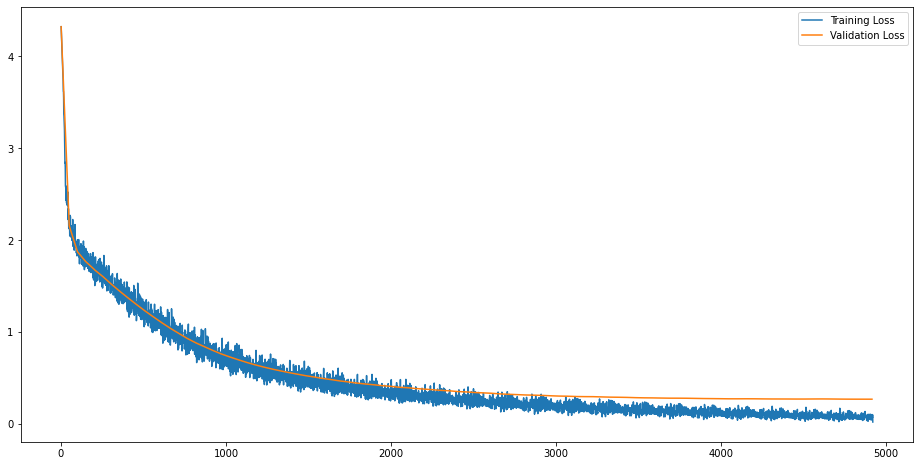

In [17]:
#Training the model and viz train and val loss
train_loss, train_iter, valid_loss, valid_iter = train(batch_size=64, num_epochs=24, print_every=50)

fig, ax = plt.subplots(figsize=(16,8))
plt.plot(train_iter, train_loss, label = "Training Loss")
plt.plot(valid_iter, valid_loss, label = "Validation Loss")
plt.legend()
plt.show()

### Save the model parameters

In [18]:
torch.save(slot_filling_net.state_dict(), "snips_slot_filling_model")

# Evaluation of the Trained Model

### Loading the saved model

In [19]:
slot_filling_net = SlotFillingNetwork(vocab_size, slots_size, embedding_size = 100, hidden_size = 100).to(device)
slot_filling_net.load_state_dict(torch.load('snips_slot_filling_model'))

<All keys matched successfully>

## Evaluating the model

In [20]:
def predictSlots(sentence, actual_slots):
    sent_indices = torch.tensor(indexFromSentence([sentence]), device=device)
    sent_len = torch.tensor([sent_indices.shape[1]], device=device)

    with torch.no_grad():
        hidden = slot_filling_net.initHidden(1)
        slot_predicted, hidden = slot_filling_net.forward(sent_indices, sent_len, hidden)
        topv, topi = slot_predicted.data.topk(1)
        slots_pred = []
        accuracy = 0
        for i, index in enumerate(topi.squeeze()):
            slots_pred.append(indices_to_slots[index.item()])
            if indices_to_slots[index.item()] == actual_slots.split()[i]:
                accuracy += 1
        accuracy = accuracy * 100 / sent_len
        
    return slots_pred, accuracy

def evaluateSentence(sentence, actual_slots):

    slots_pred, acc = predictSlots(sentence, actual_slots)
    df = pd.DataFrame({"Word": sentence.split(), "Predicted Slot": slots_pred, "Actual Slot": actual_slots.split()})
    print(df)
    
    print("\nAccuracy: %.2f" % (acc))

In [21]:
def loadTestData(seq_in_path, seq_out_path):
    with open(seq_in_path, "r") as file:
        input_sent = file.readlines()
    input_sent = addMarkers(input_sent)

    with open(seq_out_path, "r") as file:
        output_slots = file.readlines()
    output_slots = addMarkers(output_slots)

    df = pd.DataFrame({"sentence": input_sent, "slots": output_slots})
    return df

In [22]:
test_df = loadTestData("test/seq.in", "test/seq.out")
test_df.tail()

,sentence,slots
695,BOS find a tv series called armageddon summer\...,BOS O O B-object_type I-object_type O B-object...
696,BOS find politicsnation with al sharpton \n EOS,BOS O B-object_name I-object_name I-object_nam...
697,BOS rate this album 0 points out of 6\n EOS,BOS O B-object_select B-object_type B-rating_v...
698,BOS add leah kauffman to my uncharted 4 nathan...,BOS O B-artist I-artist O B-playlist_owner B-p...
699,BOS rate this album two out of 6 EOS,BOS O B-object_select B-object_type B-rating_v...


In [23]:
def testModel(test_df):
    tot_correct = 0
    tot_samples = 0
    slots = 0
    missing_slot = 0
    spurious_slot = 0
    wrong_boundary = 0
    wrong_label = 0
    slot_wrong = dict()
    label_wrong = dict()
    for index, row in test_df.iterrows():
        slots_pred, acc = predictSlots(row["sentence"], row["slots"])
        tot_correct += acc/100.0 * len(row["sentence"].split())
        tot_samples += len(row["slots"].split())

        for pred, actual in zip(slots_pred, row["slots"].split()):
      
          if '-' in pred and '-' in actual:
            slots += 1
            predSlot, predLabel = pred.split('-')
            actSlot, actLabel = actual.split('-')
            #Slot mismatch - missing slot and missing label
            if predSlot != actSlot:
              missing_slot += 1
              try:
                slot_wrong[actSlot] += 1
              except KeyError as e:
                slot_wrong[actSlot] = 0
              if predLabel != actLabel:
                wrong_label += 1

            #Label mismatch - spurios slot and wrong boundary
            if predLabel != actLabel:
              spurious_slot += 1
              if predLabel in actLabel or actLabel in predLabel:
                wrong_boundary += 1
              try:
                label_wrong[actLabel] += 1
              except KeyError as e:
                label_wrong[actLabel] = 0
            
    
    test_acc = tot_correct/tot_samples * 100
    print(f'Slot + Label (Overall) Accuracy: {test_acc.item():.2f}%\nBreakdown:')
    print(f'Total number of predictions = {slots}')
    print(f'\t{missing_slot} predictions have a wrong slot \t\t\t{(slots-missing_slot)/slots*100:.2f}% slot accuracy')
    print(f'\t{spurious_slot} predictions have a wrong label \t\t\t{(slots - spurious_slot)/slots * 100:.2f}% label accuracy')
    print(f'\t{wrong_label} predictions have a wrong label but right slot \t{(slots - wrong_label)/slots * 100:.2f}% accuracy')
    print(f'\t{wrong_boundary} have predicted label as substring of actual label \t(or vice versa)')
    print(f'\tTotal wrong predictions = {missing_slot+spurious_slot+wrong_label+wrong_boundary}')
    print(f'\nMost wrongly predicted slots:\n\t{dict(sorted(slot_wrong.items(), key=lambda item: item[1], reverse=True))}')
    print(f'\nMost wrongly predicted labels:\n\t{dict(sorted(label_wrong.items(), key=lambda item: item[1], reverse=True)[:7])}')

In [24]:
testModel(test_df)

Slot + Label (Overall) Accuracy: 92.80%
Breakdown:
Total number of predictions = 3158
	129 predictions have a wrong slot 			95.92% slot accuracy
	303 predictions have a wrong label 			90.41% label accuracy
	65 predictions have a wrong label but right slot 	97.94% accuracy
	3 have predicted label as substring of actual label 	(or vice versa)
	Total wrong predictions = 500

Most wrongly predicted slots:
	{'I': 75, 'B': 52}

Most wrongly predicted labels:
	{'artist': 61, 'object_name': 34, 'country': 28, 'movie_name': 28, 'album': 20, 'state': 17, 'entity_name': 13}


In [25]:
train_df.to_csv('Train.csv')
valid_df.to_csv('Valid.csv')
test_df.to_csv('Test.csv')